# Graph-based dimensionality reduction - Does the graph help highlighting the structure in the data?


---

### _Zichen Wang, PhD_
### Ma'ayan lab meeting
### Oct. 13, 2017

---

# Refresher on graph theory

+ $G(V, E)$: a set of vertices/nodes $V$ connected by a set of edges $E$. Edges in the graph can be directed or undirected.
![Undirected graph](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/6n-graf.svg/500px-6n-graf.svg.png)

+ Important concepts:
    - **Degree**: number of edges for a given node
    - **Degree distribution**: probability distribution of degree of nodes.    
    power-law degree distribution:
    ![power-law degree distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Barabasi-albert_model_degree_distribution.svg/731px-Barabasi-albert_model_degree_distribution.svg.png)
    Random network and scale-free network:
    ![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/Scale-free_network_sample.png/800px-Scale-free_network_sample.png)
    - **Adjacency matrix**: $$
    \mathbf{A} = [A_{ij}] = 
    \begin{cases}
      0, & \text{if node i, j are not connected}\  \\
      w_{ij}, & \text{otherwise}
    \end{cases}
    $$
    
    - **Centrality**: indicators of centrality identify the most important vertices within a graph. Applications include identifying the most influential person(s) in a social network, key infrastructure nodes in the Internet or urban networks, and super-spreaders of disease.
    
    ![node centrality](https://upload.wikimedia.org/wikipedia/commons/1/11/6_centrality_measures.png)
     A) Betweenness centrality, B) Closeness centrality, C) Eigenvector centrality, D) Degree centrality, E) Harmonic Centrality and F) Katz centrality
    
    - **Edge centrality**: indicators of the importantance of edges in a graph.
        + Shortest path based: edge betweenness centrality
        + Random walk based: Mean first passage time, Mean commute time
        
    ![edge centrality](http://reference.wolfram.com/language/ref/Files/EdgeBetweennessCentrality.en/O_2.png)
    

In [1]:
import os
import sys
import json
from itertools import combinations

import numpy as np
import pandas as pd
import networkx as nx
from sklearn import preprocessing, manifold, decomposition, neighbors, cluster, metrics

from tensorflow.examples.tutorials.mnist import input_data

import requests

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')
from IPython import display

COLORS10 = sns.color_palette("Set2", 10)

np.random.seed(2017)

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sys.path.append('/Users/zichen/Documents/Zichen_Projects/DrugPage/embedding-projector/notebooks/')
from graph_utils import *

<IPython.core.display.Javascript object>

# 0. Prepare data

Retrieve the MNIST data and sample a subset to experiment on.

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
print mnist.train.num_examples
print mnist.test.num_examples

55000
10000


In [6]:
N = 1000 # number of samples
X, labels = mnist.train.next_batch(N)
print X.shape, labels.shape
print np.unique(labels)

(1000, 784) (1000,)
[0 1 2 3 4 5 6 7 8 9]


In [7]:
print X.shape, labels.shape

(1000, 784) (1000,)


# 1. Does the graph help highlighting the structure in the data?

To answer this question, I perform clustering on the adjacency matrix, then evaluate the resultant clustering with the true labels using AMI.

### Workflow: 

0. Given data matrix **X** (_m_ samples by _n_ features), with labels **y** (_m_ samples), compute a pairwise similiarity matrix **A** (_m_ samples by _m_ samples)
0. Create graph $G(V, E)$ (thresholding or kNN) from the original pairwise similiarity matrix $\mathbf{A}$ from data, the corresponding adjacency matrix of the graph is $\mathbf{A_g}$
0. Cluster $\mathbf{A_g}$
0. Evaluate the clustering results against **y** using AMI.

### Bonus:

Can I use the edge centrality matrix instead of adjacency matrix?


## Clustering performance evaluation metric

**Adjusted Mutual Information (AMI)** is an adjustment of the Mutual Information (MI) score to account for chance. It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared.

- Advantages: 
    + Symetric
    + Random (uniform) label assignments have a AMI score close to 0.0
    + Bounded range [0, 1]
    + No assumption is made on the cluster structure
- Disadvantages:
    + Require the knowledge of the ground truth classes
    

In [8]:
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
labels_pred2 = [0, 1, 2, 3, 4, 5]
# AMI is Symetric:
print metrics.adjusted_mutual_info_score(labels_true, labels_pred)
print metrics.adjusted_mutual_info_score(labels_pred, labels_true)
# a perfect AMI is 1.
print metrics.adjusted_mutual_info_score(labels_true, labels_true)
# the worest AMI 
print metrics.adjusted_mutual_info_score(labels_true, labels_pred2)

0.225042283198
0.225042283198
1.0
1.01056854732e-16


## 1.1. Compute pairwise similarity matrix for the data 

In [9]:
# Compute adjacency matrix
def compute_adjcency_mat(X, metric='euclidean'):
    pdist = dist.squareform(pairwise_distances(X, metric=metric), checks=False)
    # Normalize to [0, 1]
    pdist /= pdist.max()
    # Convert to adj_mat
    adj_mat = 1 - pdist
    return adj_mat


In [10]:
# adj_mat = compute_adjcency_mat(X, metric='correlation')
adj_mat = compute_adjcency_mat(X, metric='euclidean')
print adj_mat.shape
print adj_mat.min(), adj_mat.max()


(499500,)
0.0 0.889783140625


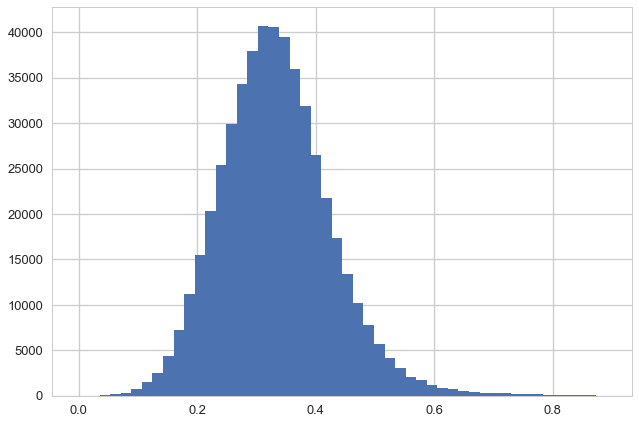

In [11]:
plt.hist(adj_mat, bins=50);

/usr/local/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


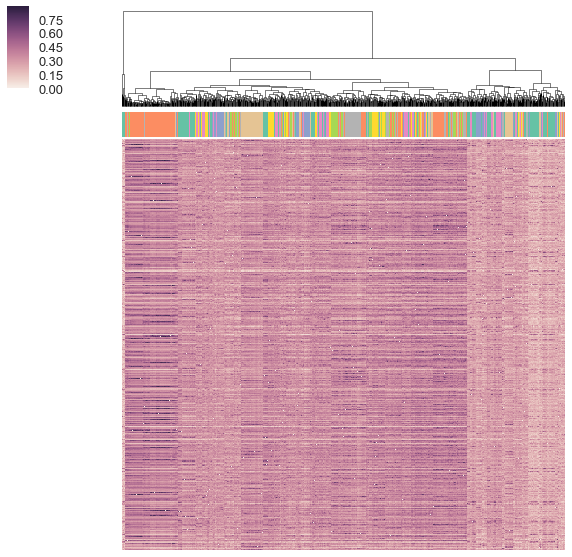

In [12]:
# Visualize the adj_mat
col_colors = [COLORS10[i] for i in labels]

sns.clustermap(dist.squareform(adj_mat), 
               col_colors=col_colors, 
               row_cluster=False,
               xticklabels=False,
               yticklabels=False
              )

## 1.2. Create graphs for different thresholds and cluster the adjacency matrices for the graphs

In [13]:
def cluster_adj_mat(adj_mat):
    assert adj_mat.ndim == 2
    clstr = cluster.AffinityPropagation(affinity='precomputed')
    clstr.fit(adj_mat)    
    return clstr.labels_

Percentile: 0.00, cutoff value: 0.00000, MI score: 0.33797
Percentile: 25.00, cutoff value: 0.27002, MI score: 0.33797
Percentile: 50.00, cutoff value: 0.32788, MI score: 0.38594
Percentile: 75.00, cutoff value: 0.38820, MI score: 0.38109
Percentile: 90.00, cutoff value: 0.44936, MI score: 0.37481
Percentile: 95.00, cutoff value: 0.49160, MI score: 0.33885
Percentile: 99.00, cutoff value: 0.59482, MI score: 0.21465
Percentile: 99.50, cutoff value: 0.64645, MI score: 0.13246
Percentile: 99.90, cutoff value: 0.76170, MI score: 0.03688


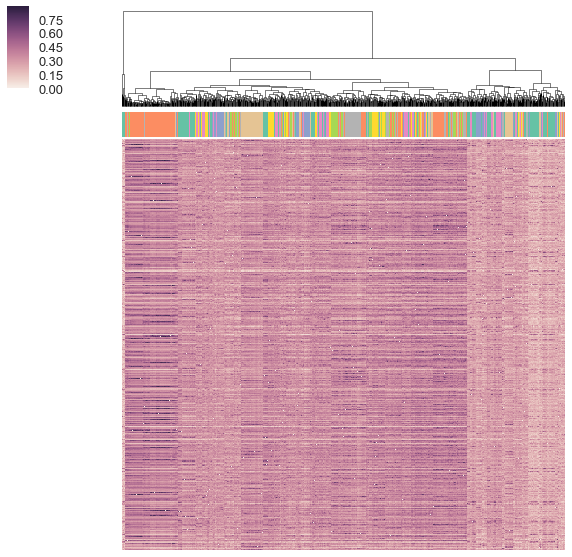

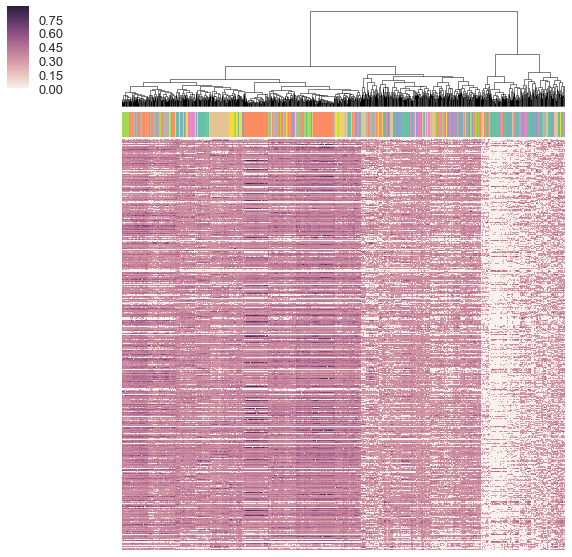

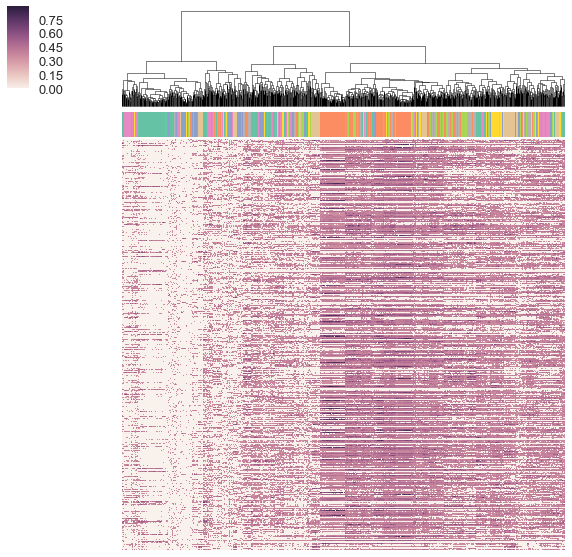

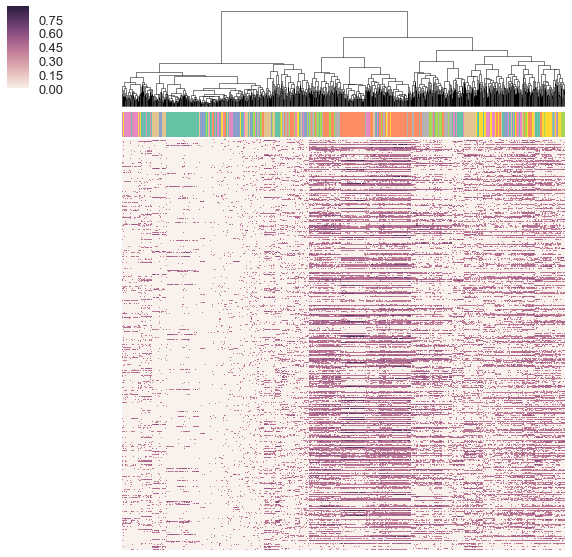

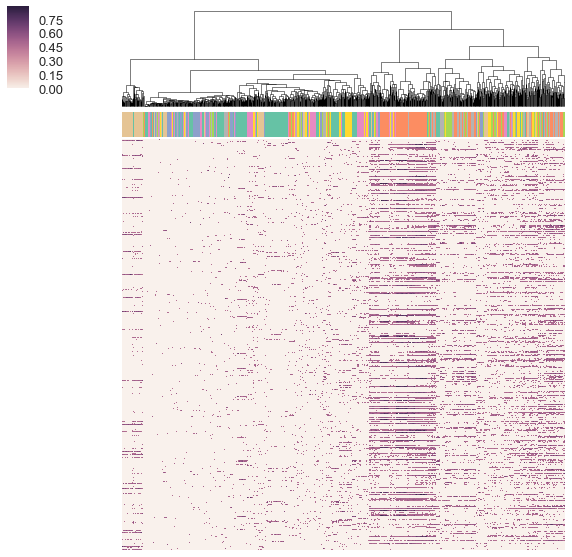

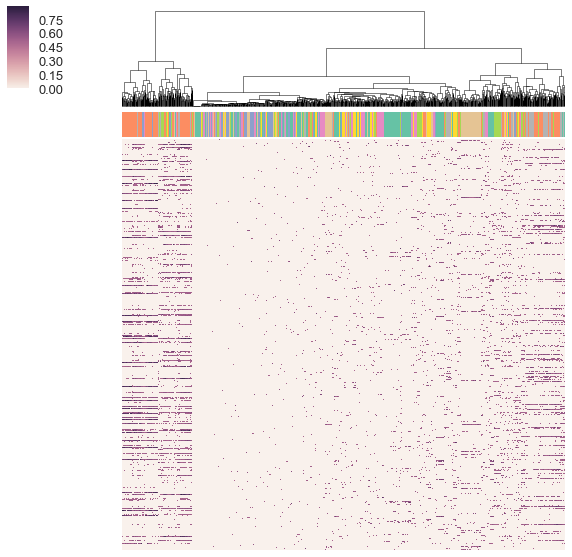

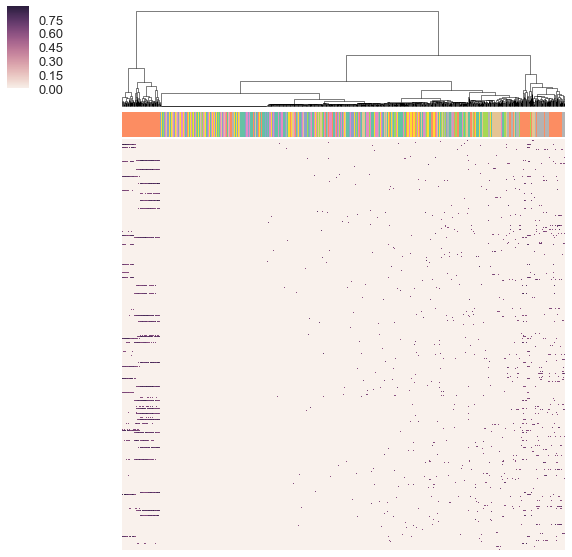

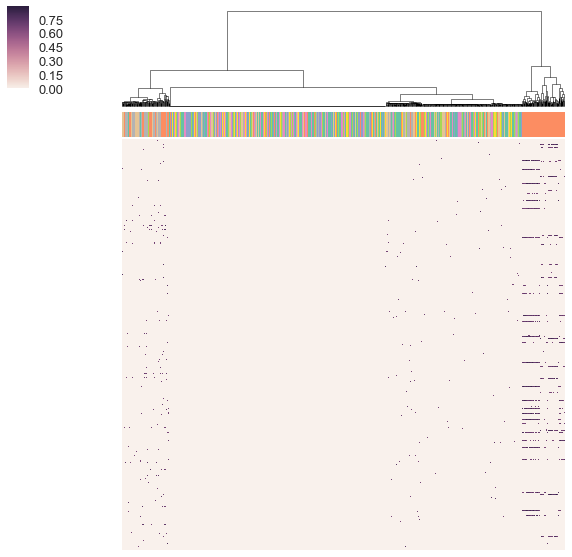

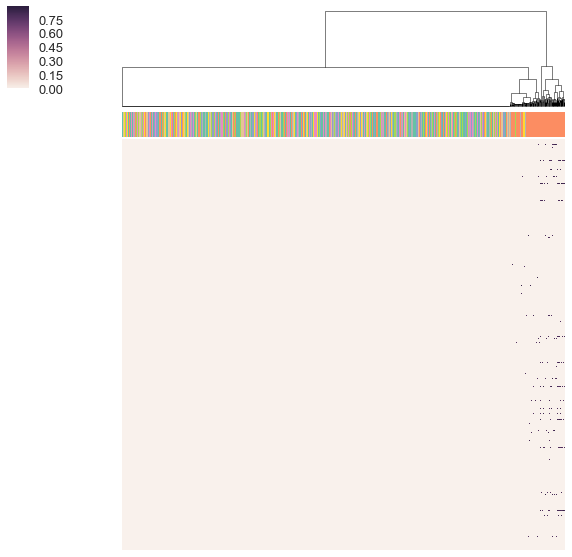

In [14]:
percentiles = [0, 25, 50, 75, 90, 95, 99, 99.5, 99.9]

col_colors = [COLORS10[i] for i in labels]
AMIs = []

labels_pred_mat = np.zeros((len(percentiles), len(labels)))

for i, percentile in enumerate(percentiles):
    threshold = np.percentile(adj_mat, percentile)
    # Thresholding the original adj_mat
    adj_mat_ = adj_mat.copy()
    adj_mat_[adj_mat<threshold] = 0
    adj_mat_ = dist.squareform(adj_mat_)

    labels_pred = cluster_adj_mat(adj_mat_)
    labels_pred_mat[i] = labels_pred
    
    ami = metrics.adjusted_mutual_info_score(labels, labels_pred)
    AMIs.append(ami)
    print 'Percentile: %.2f, cutoff value: %.5f, MI score: %.5f' %(percentile, threshold, ami)
    sns.clustermap(adj_mat_, 
                   col_colors=col_colors, 
                   row_cluster=False,
                   xticklabels=False,
                   yticklabels=False
                  )

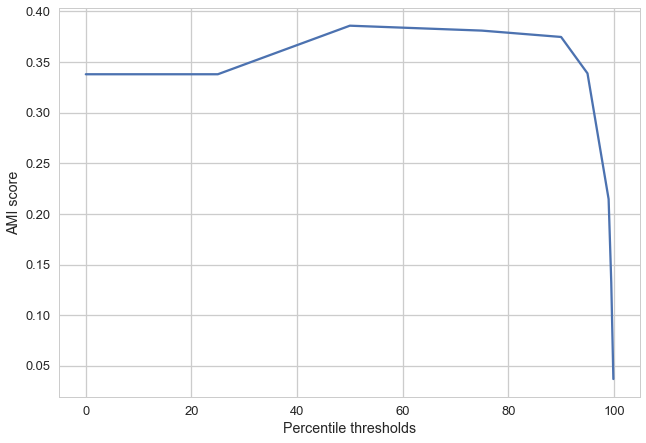

In [15]:
# AMI across different thresholds for creating the network
plt.plot(percentiles, AMIs)
plt.xlabel('Percentile thresholds')
plt.ylabel('AMI score')

### How similar are the networks in terms of clustering?

(10, 1000)


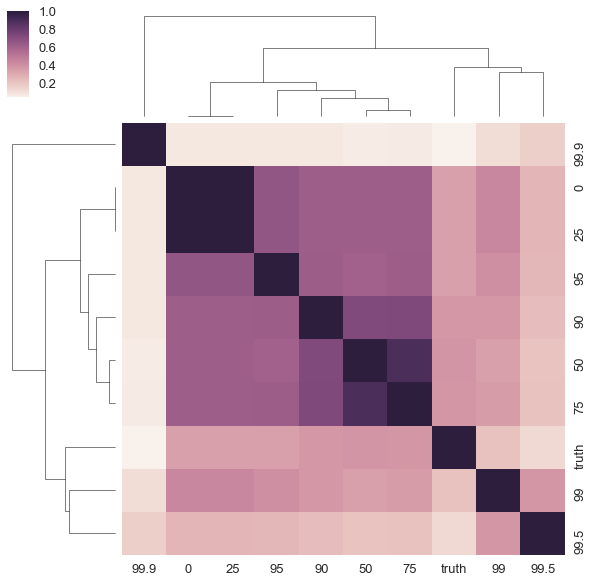

In [16]:
# Pairwise similarities of those clusters with the truth
labels_pred_mat_with_truth = np.vstack((labels_pred_mat, labels.reshape(1, -1)))
print labels_pred_mat_with_truth.shape
n = labels_pred_mat_with_truth.shape[0]

AMI_mat = np.ones((n,n))

for i, j in combinations(range(n), 2):
    ami = metrics.adjusted_mutual_info_score(labels_pred_mat_with_truth[i], labels_pred_mat_with_truth[j])
    AMI_mat[i,j] = ami
    AMI_mat[j,i] = ami

AMI_mat = pd.DataFrame(AMI_mat,
                       index=percentiles+['truth'],
                       columns=percentiles+['truth'],
                                         )
sns.clustermap(AMI_mat)

In [1]:
import seaborn as sns
sns.__version__

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


'0.6.0'

In [17]:
# In the last graph, find nodes with edges
mask_nodes_with_edges = adj_mat_.sum(axis=1) > 0
print mask_nodes_with_edges.sum()

125


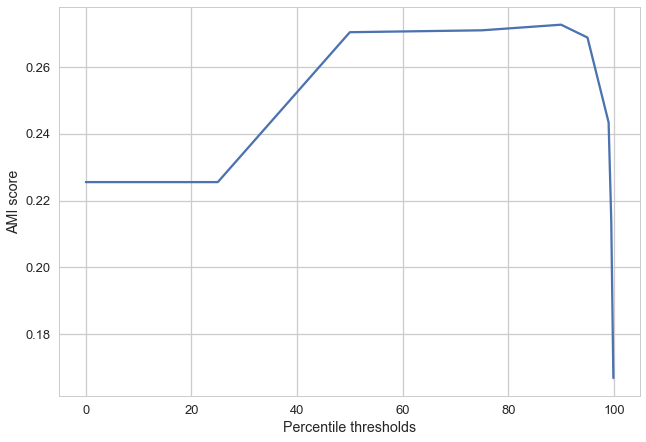

In [18]:
# Re-compute AMIs on these nodes in the last graph
AMIs_last_graph = []
for i in range(len(percentiles)):
    labels_pred = labels_pred_mat[i]
    ami = metrics.adjusted_mutual_info_score(labels[mask_nodes_with_edges], 
                                             labels_pred[mask_nodes_with_edges])
    AMIs_last_graph.append(ami)

plt.plot(percentiles, AMIs_last_graph)
plt.xlabel('Percentile thresholds')
plt.ylabel('AMI score')

(10, 1000)


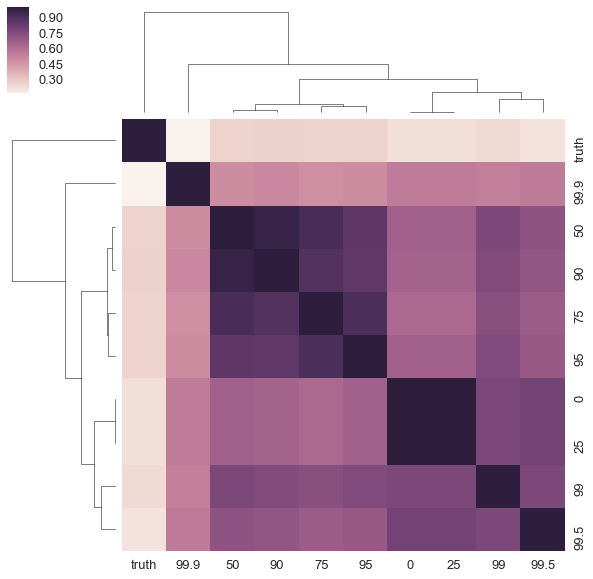

In [19]:
# Pairwise similarities of those clusters with the truth
labels_pred_mat_with_truth = np.vstack((labels_pred_mat, labels.reshape(1, -1)))
print labels_pred_mat_with_truth.shape
n = labels_pred_mat_with_truth.shape[0]

AMI_mat = np.ones((n,n))

for i, j in combinations(range(n), 2):
    ami = metrics.adjusted_mutual_info_score(labels_pred_mat_with_truth[i][mask_nodes_with_edges], 
                                             labels_pred_mat_with_truth[j][mask_nodes_with_edges])
    AMI_mat[i,j] = ami
    AMI_mat[j,i] = ami

AMI_mat = pd.DataFrame(AMI_mat,
                       index=percentiles+['truth'],
                       columns=percentiles+['truth'],
                                         )
sns.clustermap(AMI_mat)

## 1.3. Create graphs by kNN and cluster the adjacency matrices for the graphs

In [20]:
def create_adj_mat_from_knn_graph(X, k, adj_mat, metric='euclidean'):
    sparse_adj_mat = neighbors.kneighbors_graph(X, k, mode='connectivity', 
                                                metric=metric)
    
    mask = sparse_adj_mat > 0
    adj_mat_knn = dist.squareform(adj_mat) * mask.astype(int)

    return dist.squareform(adj_mat_knn, checks=False)

In [22]:
print adj_mat.shape
adj_mat_knn = create_adj_mat_from_knn_graph(X, 3, adj_mat)
print adj_mat_knn.shape

(499500,)
(499500,)


k: 1, MI score: 0.20796
k: 3, MI score: 0.26272
k: 5, MI score: 0.26637
k: 10, MI score: 0.25928
k: 15, MI score: 0.26285
k: 20, MI score: 0.25161
k: 30, MI score: 0.18974
k: 50, MI score: 0.16284
k: 100, MI score: 0.00163
k: 200, MI score: 0.00567
k: 1000, MI score: 0.33797


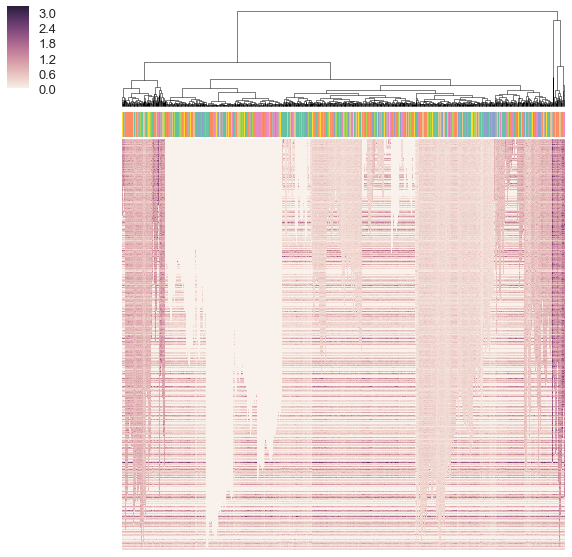

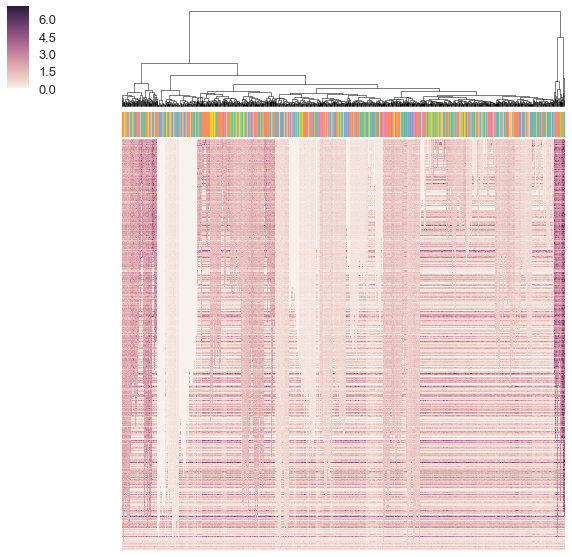

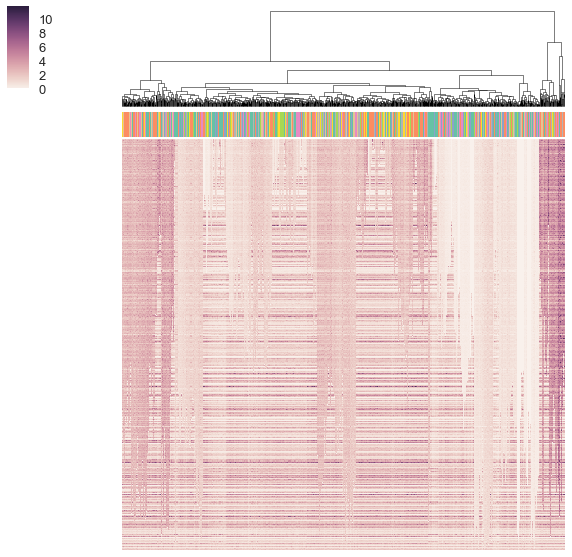

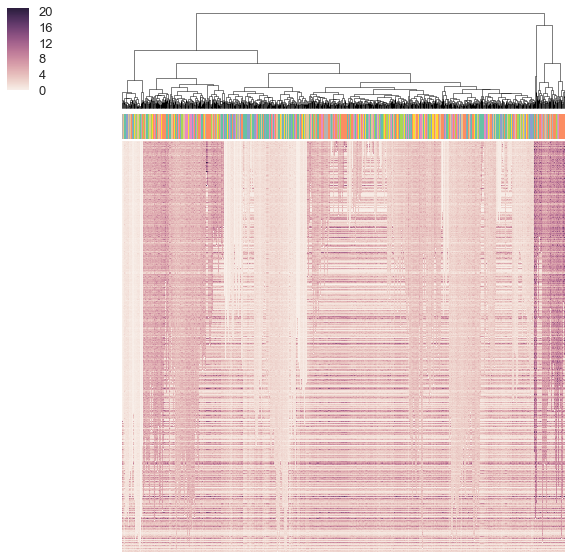

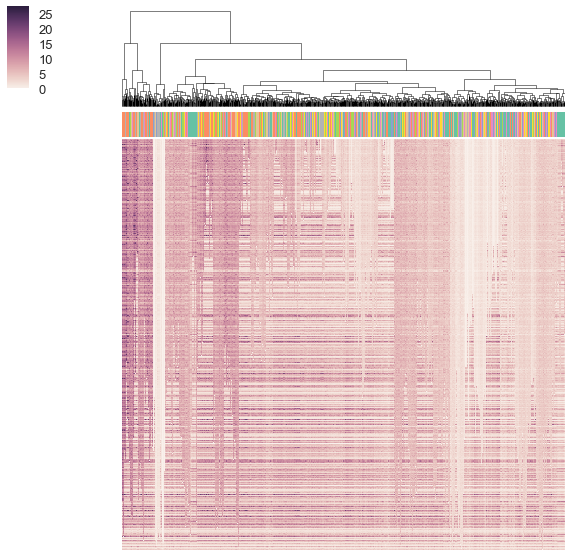

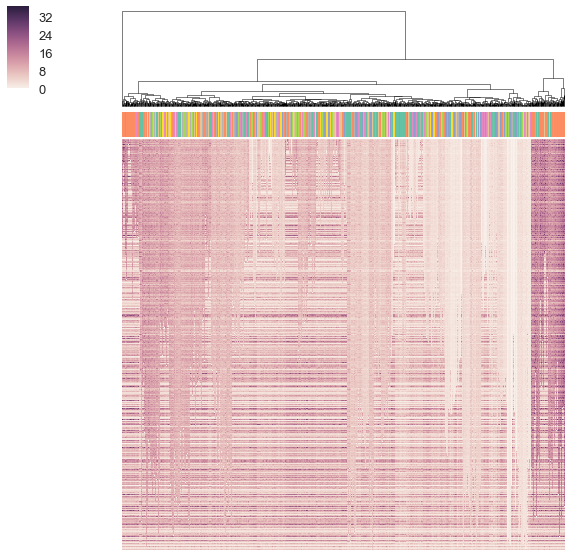

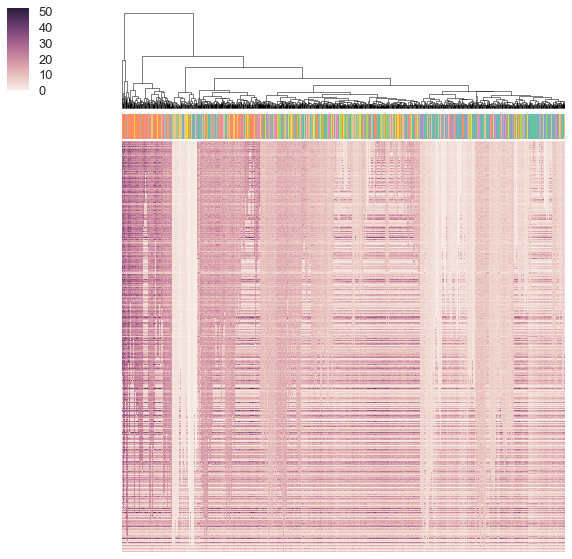

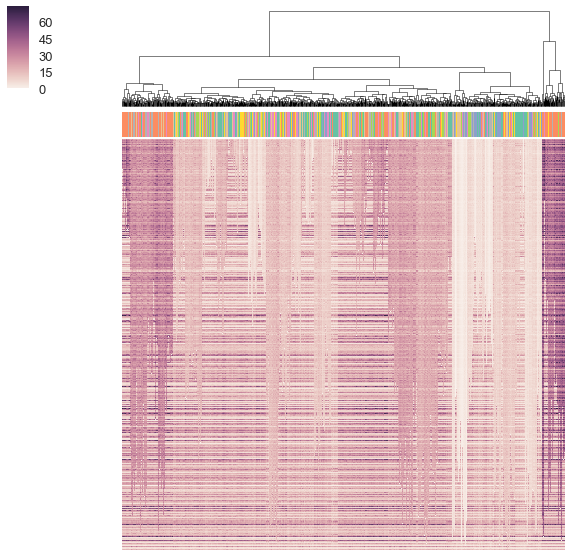

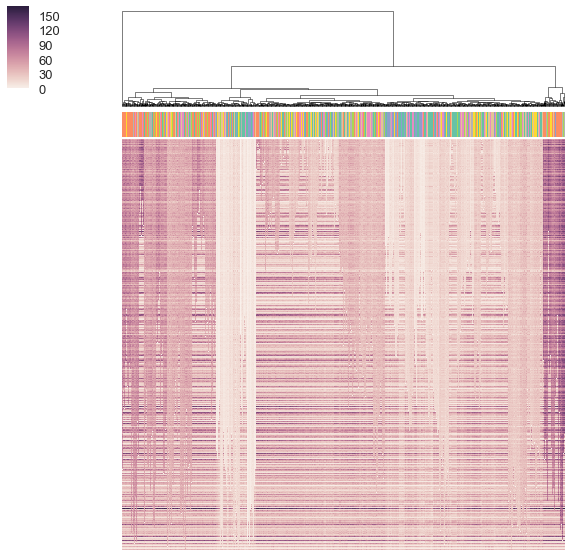

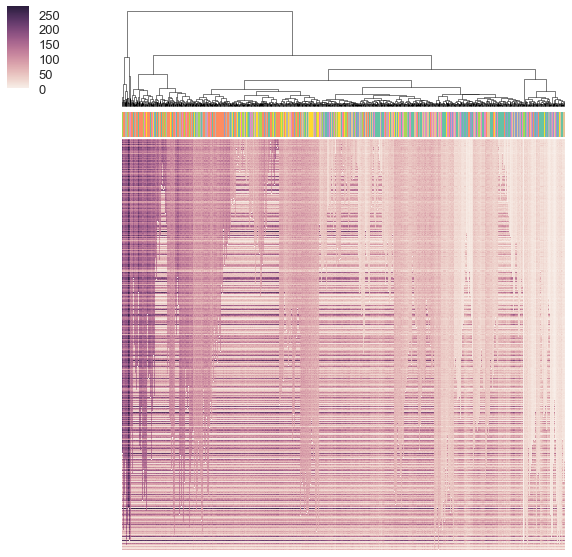

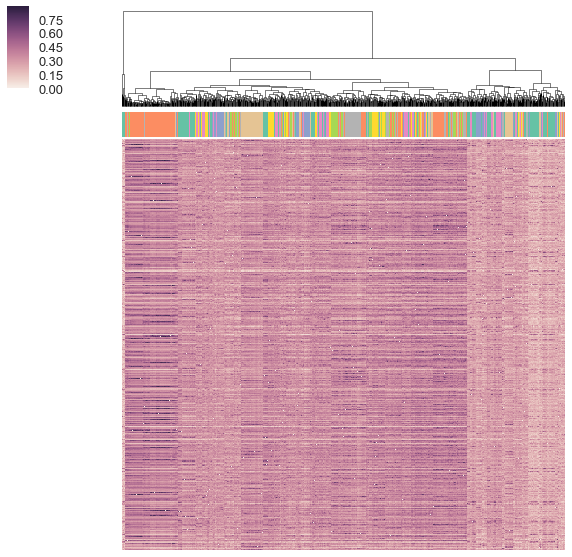

In [23]:
ks = [1,3,5,10,15,20,30,50,100,200,1000]
col_colors = [COLORS10[i] for i in labels]
AMIs = []

labels_pred_mat = np.zeros((len(ks), len(labels)))

for i, k in enumerate(ks):
    if k != 1000:
        adj_mat_knn = create_adj_mat_from_knn_graph(X, k, adj_mat)
        adj_mat_knn = dist.squareform(adj_mat_knn)
    else:
        adj_mat_knn = dist.squareform(adj_mat)
    
    labels_pred = cluster_adj_mat(adj_mat_knn)
    labels_pred_mat[i] = labels_pred
    
    ami = metrics.adjusted_mutual_info_score(labels, labels_pred)
    AMIs.append(ami)
    
    print 'k: %d, MI score: %.5f' %(k, ami)
    sns.clustermap(adj_mat_knn, 
                   col_colors=col_colors, 
                   row_cluster=False,
                   xticklabels=False,
                   yticklabels=False
                  )
        

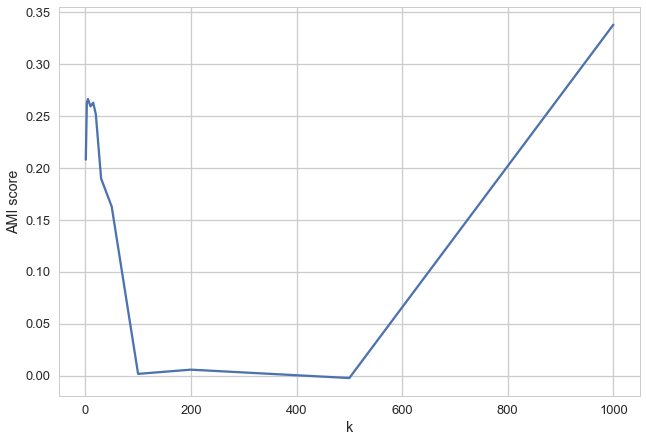

In [31]:
# AMI across different ks for creating the network
plt.plot(ks, AMIs)
plt.xlabel('k')
plt.ylabel('AMI score')

### How similar are the networks in terms of clustering?

(13, 1000)


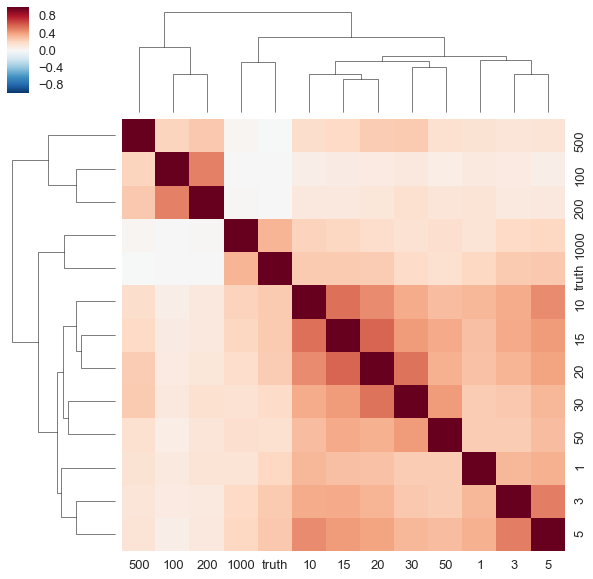

In [32]:
# Pairwise similarities of those clusters with the truth
labels_pred_mat_with_truth = np.vstack((labels_pred_mat, labels.reshape(1, -1)))
print labels_pred_mat_with_truth.shape
n = labels_pred_mat_with_truth.shape[0]

AMI_mat = np.ones((n,n))

for i, j in combinations(range(n), 2):
    ami = metrics.adjusted_mutual_info_score(labels_pred_mat_with_truth[i], labels_pred_mat_with_truth[j])
    AMI_mat[i,j] = ami
    AMI_mat[j,i] = ami

AMI_mat = pd.DataFrame(AMI_mat,
                       index=ks+['truth'],
                       columns=ks+['truth'],
                                         )
sns.clustermap(AMI_mat)

# 2. Use edge betweenness centrality matrix instead of adjacency matrix for clustering

In [35]:
def compute_edge_betweenness_matrix(G, k_div=10):
    eb = nx.edge_betweenness_centrality(G, 
                                        k=int(G.number_of_nodes()/k_div), 
                                        weight='weight')
    n = max(G.nodes()) + 1
    mat = np.zeros((n,n))
    for (n1, n2), val in eb.items():
        mat[n1,n2] = val
        mat[n2,n1] = val
    return mat

def create_graph_by_threshold(adj_mat, percentile):
    threshold = np.percentile(adj_mat, percentile)
    print threshold
    adj_mat_ = adj_mat.copy()
    adj_mat_[adj_mat<threshold] = 0
    G = nx.from_numpy_matrix(dist.squareform(adj_mat_))
    return G

0.0
1000 499499
Percentile: 0.00, MI score: 0.08856
0.270015267744
1000 374626
Percentile: 25.00, MI score: 0.01861
0.327882934882
1000 249750
Percentile: 50.00, MI score: 0.04000
0.388198437228
1000 124875
Percentile: 75.00, MI score: 0.08483
0.449355428117
1000 49950
Percentile: 90.00, MI score: 0.12397
0.491603847037
1000 24975
Percentile: 95.00, MI score: 0.15303
0.594815700951
1000 4995
Percentile: 99.00, MI score: 0.13980
0.64645073251
1000 2498
Percentile: 99.50, MI score: 0.08611
0.761698429439
1000 500
Percentile: 99.90, MI score: 0.02680


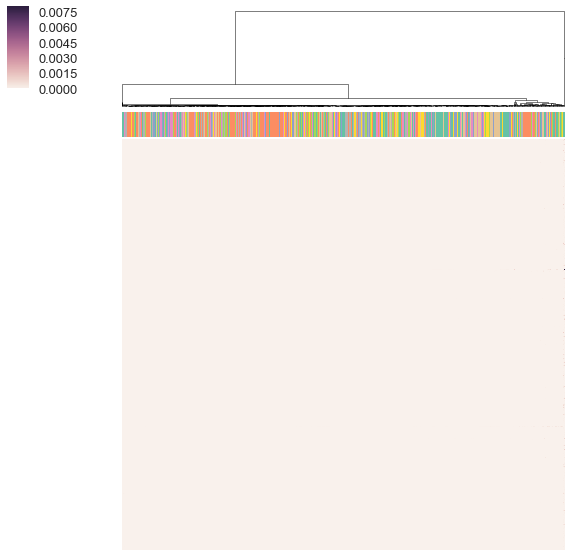

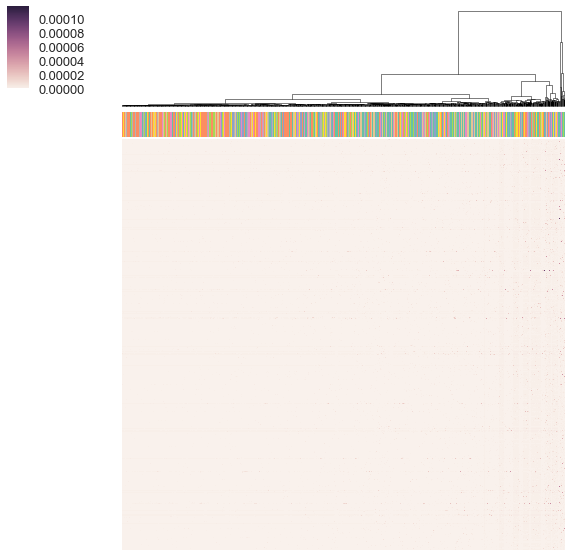

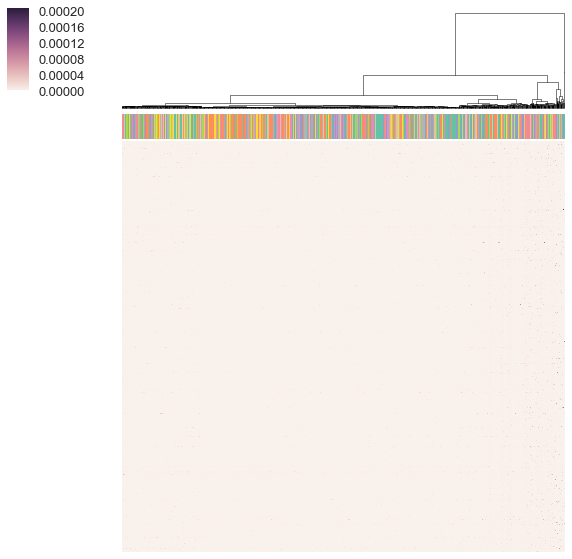

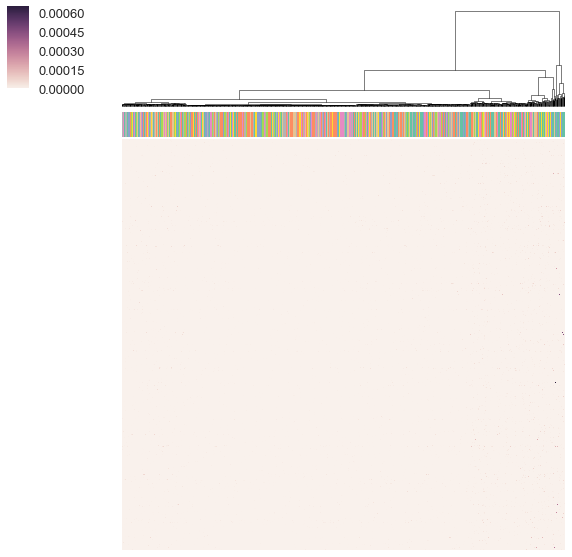

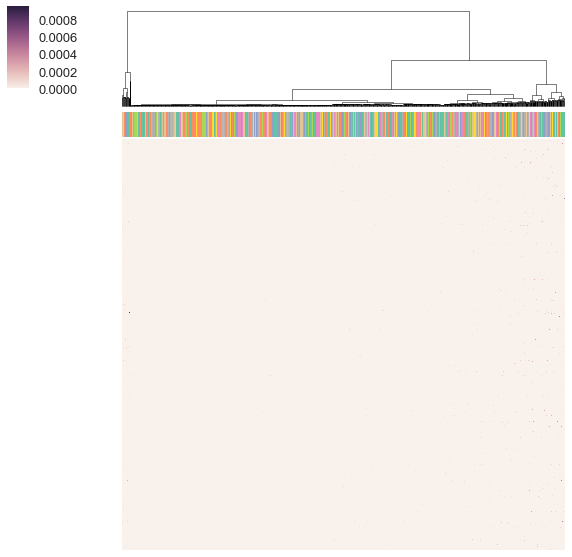

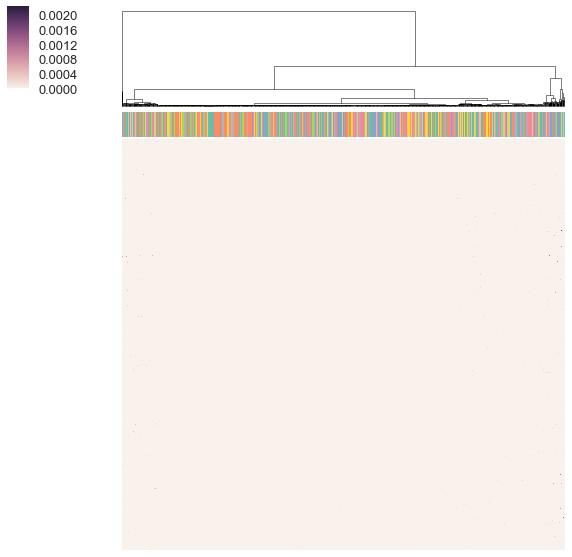

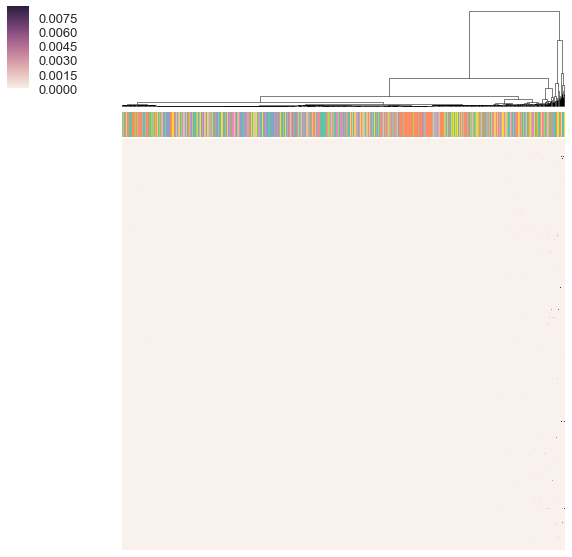

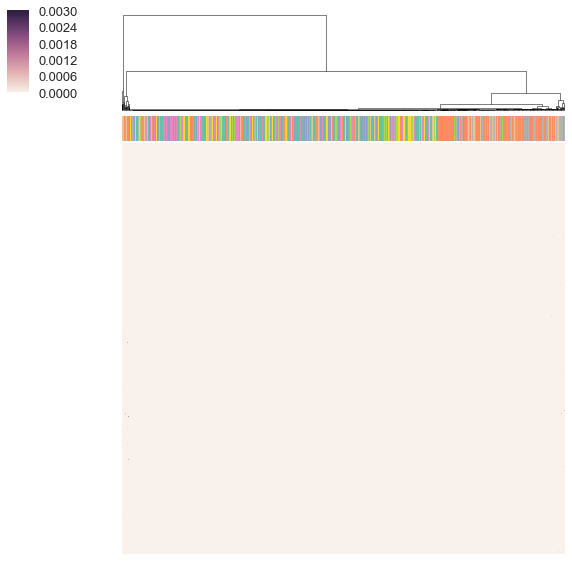

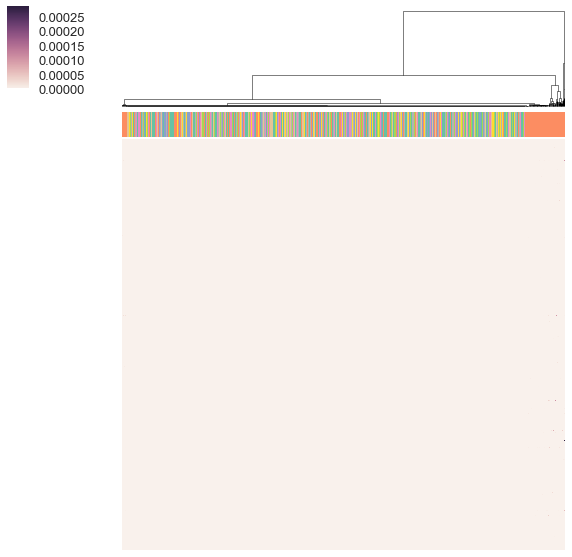

In [39]:
percentiles = [0, 25, 50, 75, 90, 95, 99, 99.5, 99.9]

col_colors = [COLORS10[i] for i in labels]
AMIs = []

labels_pred_mat = np.zeros((len(percentiles), len(labels)))

for i, percentile in enumerate(percentiles):
    G = create_graph_by_threshold(adj_mat, percentile)
    print G.number_of_nodes(), G.number_of_edges()
    eb_mat = compute_edge_betweenness_matrix(G)
    
    labels_pred = cluster_adj_mat(eb_mat)
    labels_pred_mat[i] = labels_pred
    
    ami = metrics.adjusted_mutual_info_score(labels, labels_pred)
    AMIs.append(ami)
    print 'Percentile: %.2f, MI score: %.5f' %(percentile, ami)
    sns.clustermap(eb_mat, 
                   col_colors=col_colors, 
                   row_cluster=False,
                   xticklabels=False,
                   yticklabels=False
                  )

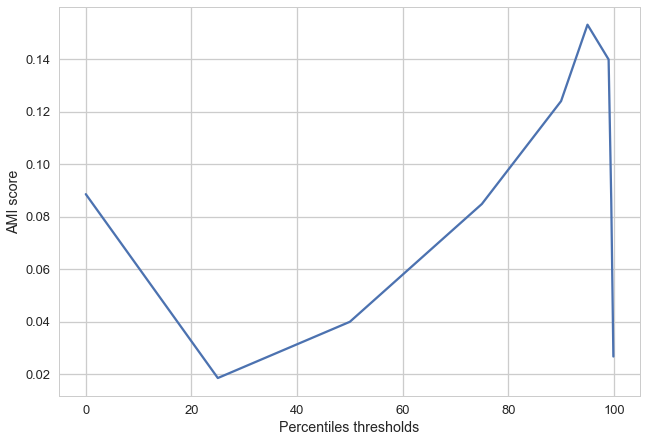

In [40]:
# AMI across different thresholds for creating the network
plt.plot(percentiles, AMIs)
plt.xlabel('Percentiles thresholds')
plt.ylabel('AMI score')

# Conclusion: constructing graph on the pairwise similarity matrix does help bringing out the structure in the data 